# Forecasting Real-Estate Property Value around Chicago Metropolitan Area
Modeling and analysis by Matt Carr, Johnhoy Stephens, and Luluva Lakdawala

## Setting the Scene:

This project investigates the trend in the market value of homes around the Chicago metropolitan area and uses times series modeling techniques to make forecasts for a one year time period. Using the forecasts made with our models, Return on Investment (ROI) are calculated for each forecast and the best regions are selected purely based on ROI. Real Estate investments are capital intensive and locating properties in which to invest can involve substantial work. We aim to provide a guide for narrowing down this search and provide a list of Zip codes for properties to invest in. 

### Goals:

Our project aims to:
- Identify regions around Chicago metropolitan area where the market value of properties have seen steady growth over the years.
- Build Time Series Models based on the values of homes sold in the past in those regions.
- Make forecasts of median home prices for the identified regions.
- Make recommendations for investment in real estate in Zip Codes that exhibit the best return on investment.

### Definitions:

- Return on Investment:
    - Return on Investment (ROI) is defined as a performance measure used to calculate the efficiency of an investment. To calculate ROI - the return is divided by the cost of investment.
        

- Historical ROI :
    - Similar to ROI but it is calculated on historical data -> (present value less past value) divided by past value.
    

- Model:
    - The term model referred to through this project is in reference to the variuos Time Series Models that are built for making forecasts.
    
    
- AIC score:
    - The metric we are using to compare the various models we build. Akaike information criterion (AIC) is a defined as an estimator that calculates the prediction error of a model. It estimates the quality of a model relative to other models. A good model is the one that has minimum AIC among all the other models.
    
### Data:

The data used in this project is from [Zillow Research Page](https://www.zillow.com/research/data/)



### Analysis Takeaways and Recommendations:
- Top 5 Zip codes identified are: 46327, 60505, 60436, 60651, 60633
- The projected Return on Investments from these Zipcodes are: 17.77%, 10.67%, 10,64%, 10.10%, 9.44% respectively
- The projected returns are calculated based on the difference in the market value of property prices for one year. This can be regarded as the base return. Additional income can also be generated from investing in these regions such as: rental income from the invested properties, business income generated from businesses operating in these properties and so on.
- Our analysis only guides the investment firm in narrowing down their search for areas to invest in.


### Fututre Investigations:
- How well do our current forecasts match up with future market values.
- How does the ROI from investing in the recommended regions perform against other investment instruments.
- Can we factor in risk, volatility, market conditions in our forecasts?


# Data Cleaning and Exploratory Data Analysis:


Note that this modeling analysis contains the 'stream lined' version iterations from getting our first simple model to our final models. To get a more in depth view of our exploration process, mistakes, and triumphs, please refer to the exploratory folder within the notebooks folder.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import cleaning_functions as cfs
from matplotlib.pylab import rcParams
sns.set_style('white')
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as mse

### Get data:

The data is stored in a csv file in the data folder of this repo. Run the cell below to load it into a dataframe.

In [3]:
df = cfs.load_df()
df.head(3)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900


In [4]:
df.shape

(14723, 272)

The frame contains regions from all around the country. We will subset the frame to retain only Chicago Metro area information

In [5]:
chicago_df = df[df['Metro'] == 'Chicago']
print(chicago_df.shape)
chicago_df.head(3)

(325, 272)


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800


There are **325** RegionNames aka **Zip codes** in the **Chicago Metropolitan area**. We shortlist them by selecting the top 30 regions that have had the best return on investments in the past 5 years and 2 years. We calculate the historical ROI using the following formulae:

##### $\text{Historical ROI for 5 years}  = \dfrac{\text{Value  in  April  2018  -  Value  in  April  2013}}{\text{Value  in  April  2013}} * 100$


##### $\text{Historical ROI for 2 years}  = \dfrac{\text{Value  in  April  2018  -  Value  in  April  2016}}{\text{Value  in  April  2016}} * 100$

Using the above formulae we narrowed down our search for the top 15 regions with the highest historical ROI for both time periods. We end up with 27 RegionNames (3 Regions appeared in both lists)

In [6]:
regions = cfs.zipcodes_top27()
print('The Zip codes for highest ROI in past 5 and 2 years are: ') 
print(regions)

The Zip codes for highest ROI in past 5 and 2 years are: 
[60804, 60085, 60153, 60110, 60104, 60505, 60651, 60073, 60436, 60639, 60120, 60165, 60160, 60641, 60042, 60432, 60163, 60456, 60034, 46327, 60180, 60633, 46324, 60099, 46320, 46394, 60162]


#### Visualizing the average Market Value of Homes for our regions from April 1996 to April 2018

![Market trend](../../report/figures/market_trend_22_years.png)

Out time series experienced irregular trend during the housing bubble and market crash around 2008 where home values dropped significantly over the few years following the crash. Since such irregular cycle/trend are not ideal in time series models, we decided to build two different models where:
- one accounts for all the years from 1996 through 2018 
- the other that avoids the recession years and trains only after the market was on route to recover (starting from January 2013)


After multiple iterations with the entire time series we failed to lower our AIC scores. While the models trained on the post recession period performed excellently.
For a rough comparison between these sets of data a model trained on the entire timeframe had an **AIC score** averaging in the **4200s** while a baseline(Random Walk) model trained on data post recession had an average AIC score of about **800**.

We decided to work with time series data from January 2013 onwards since our final goal was to make a reliable forecasts from well trained models.

![Market trend after recession recovery](../../report/figures/market_trend_5_years.png)

# Data Preprocessing:

The current dataframe is in a wide format that doesn't allow us to work with time series modeling.

In [7]:
chicago_df.head(2)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000


### Steps: 
- transform dataframe from `wide format` to `long format`
- filter out undesirable regions and retain the top `27 RegionNames`
- create Time Series dataframe to only include Values as entries in the Dataframe (`endogenous-y values`)
- set `time` as the index for dataframe
- subset to only retain values from `January 2013` onwards


In [8]:
data = cfs.load_data_top_27()
data.tail(3)

,60804,60085,60153,60110,60104,60505,60651,60073,60436,60639,...,60456,60034,46327,60180,60633,46324,60099,46320,46394,60162
time,,,,,,,,,,,,,,,,,,,,,
2018-02-01,162900.0,110800.0,144100.0,160100.0,148300.0,129200.0,148300.0,146300.0,114100.0,231400.0,...,123400.0,177100.0,72900.0,231500.0,112800.0,98500.0,124700.0,68500.0,117700.0,172800.0
2018-03-01,163800.0,113400.0,144800.0,161800.0,149800.0,131100.0,150300.0,147700.0,116100.0,232700.0,...,123200.0,177500.0,74000.0,234500.0,113300.0,98800.0,127000.0,68200.0,119800.0,173500.0
2018-04-01,164400.0,114500.0,145500.0,163200.0,150700.0,132100.0,150900.0,148100.0,117700.0,232600.0,...,122500.0,178000.0,74400.0,236800.0,113000.0,99100.0,127900.0,67200.0,121900.0,173800.0


## Train Test Split
**Training data -> timeline: Jan 2013 to Oct 2017**

**Testing data -> timeline: Oct 2017 to April 2018**

In [9]:
train, test = cfs.train_test_split(data, '2013-01-01', '2017-10-01')

In [10]:
train.tail(2)

,60804,60085,60153,60110,60104,60505,60651,60073,60436,60639,...,60456,60034,46327,60180,60633,46324,60099,46320,46394,60162
time,,,,,,,,,,,,,,,,,,,,,
2017-09-01,156800.0,107300.0,130400.0,154300.0,141000.0,119500.0,137300.0,140400.0,105000.0,222900.0,...,116500.0,167700.0,73200.0,222500.0,105400.0,95500.0,120000.0,68200.0,117200.0,168700.0
2017-10-01,157900.0,106800.0,133500.0,155200.0,142900.0,120800.0,139600.0,141200.0,107000.0,223300.0,...,117900.0,168700.0,72500.0,222200.0,106800.0,95700.0,121100.0,68700.0,117700.0,169000.0


In [11]:
test.tail(2)

,60804,60085,60153,60110,60104,60505,60651,60073,60436,60639,...,60456,60034,46327,60180,60633,46324,60099,46320,46394,60162
time,,,,,,,,,,,,,,,,,,,,,
2018-03-01,163800.0,113400.0,144800.0,161800.0,149800.0,131100.0,150300.0,147700.0,116100.0,232700.0,...,123200.0,177500.0,74000.0,234500.0,113300.0,98800.0,127000.0,68200.0,119800.0,173500.0
2018-04-01,164400.0,114500.0,145500.0,163200.0,150700.0,132100.0,150900.0,148100.0,117700.0,232600.0,...,122500.0,178000.0,74400.0,236800.0,113000.0,99100.0,127900.0,67200.0,121900.0,173800.0


# Modeling

We first pick one of the regions and iterate through the variuos time series models with the **goal to lower the AIC score**.

We first visualize an individual time series with auto correlation and partial auto correlation plots to understand how to pick correct orders for `p, d, q`

`PACF`, partial correlation is a **conditional correlation**. It is the  amount of correlation between a variable and a lag of itself that is not explained by correlations at all lower-order-lags. 

The shaded area of the graph is the confidence interval.  When the correlation drops into the shaded area, that means there is no longer statistically significant correlation between lags.

Some rules of thumb: 

    - A sharp drop after lag "k" suggests an AR-K model.
    - A gradual decline suggests an MA.

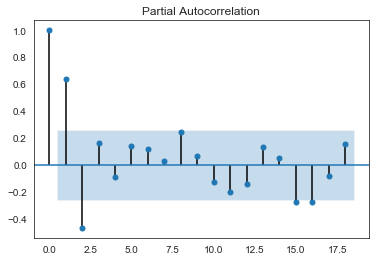

In [12]:
plot_pacf(train[60804].diff().dropna());

Since the PACF shows the direct effect of previous lags, it helps us choose AR terms.  There is a significant positive value at lag 1, this suggests that the series can benefit with one AR term. 

`ACF` 

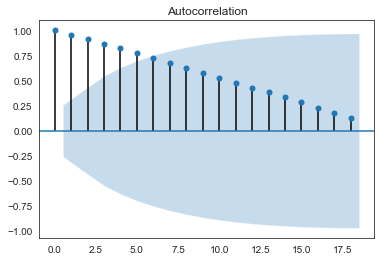

In [13]:
plot_acf(train[60804]);

When Looking at the ACF graph for the original data, we see a strong persistent correlation with higher order lags. This is evidence that we should take a **first difference** of the data to remove this autocorrelation.


`ACF` is used to predict MA terms. Moving Average models use error terms of the previous predicitons to calculate the next value. 

> If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag at which the ACF cuts off is the indicated number of MA terms.

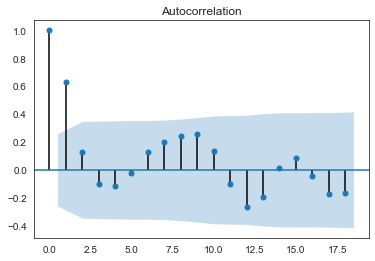

In [14]:
plot_acf(train[60804].diff().dropna());

We observe that our differenced series has a sharp cut off at lag 1, adding one MA term would be advisable. 

Next we put our theory to test and sequentially train models:
- first a Random Walk Model with order=(0,1,0)
- next an Auto-Regressive Model with order=(1,1,0)
- then a Moving Average Model with order=(0,1,1)

We shall compare each models AIC score as we progress

In [15]:
random_walk_60804 = ARIMA(train[60804].values, order=(0,1,0)).fit()
random_walk_60804.aic

943.0931969376227

In [16]:
np.sqrt(mse(train.iloc[1:, 0], random_walk_60804.predict(typ='levels')))

914.8142956058088

baseline model for our first zip code has `AIC score of 943.1` and Root Mean Squared Error of `915`

In [17]:
auto_reg_60804 = ARIMA(train[60804].values, order=(1,1,0)).fit()
auto_reg_60804.aic

913.2561078865419

`AR model` helped lower the AIC score to `913.26`

In [18]:
moving_avg_60804 = ARIMA(train[60804].values, order=(0,1,1)).fit()
moving_avg_60804.aic

897.3240637937961

`MA model` lowered AIC score further to `897`

We then try out an `ARIMA model` incorporating all three factors with order = (1,1,1)

In [19]:
arima_60804 = ARIMA(train[60804].values, order=(1,1,1)).fit()
arima_60804.aic

886.953620005091

Our least AIC score so far! We can also use `auto_arima` a form of grid search tool for ARIMA models to identify the best parameters for our orders

In [20]:
auto_arima(train[60804], start_p=0, start_q=0, max_p=6, max_q=6, seasonal=False, trace=True)

Fit ARIMA: order=(0, 1, 0); AIC=943.093, BIC=947.179, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=913.256, BIC=919.385, Fit time=0.027 seconds
Fit ARIMA: order=(0, 1, 1); AIC=897.324, BIC=903.453, Fit time=0.047 seconds
Fit ARIMA: order=(1, 1, 1); AIC=886.954, BIC=895.126, Fit time=0.080 seconds
Fit ARIMA: order=(1, 1, 2); AIC=877.539, BIC=887.754, Fit time=0.084 seconds
Fit ARIMA: order=(2, 1, 3); AIC=879.942, BIC=894.243, Fit time=0.279 seconds
Fit ARIMA: order=(0, 1, 2); AIC=875.542, BIC=883.714, Fit time=0.070 seconds
Fit ARIMA: order=(0, 1, 3); AIC=877.539, BIC=887.754, Fit time=0.091 seconds
Fit ARIMA: order=(1, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.731 seconds


ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(0, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

orders for least AIC scores = (0,1,2)

Fitting an arima model on these orders and making predictions for the same.

In [21]:
best_arima_60804 = ARIMA(train[60804].values, order=(0,1,2)).fit()
best_arima_60804.aic

875.5415199292346

inspecting mean squared error for our best arima model so far

In [22]:
np.sqrt(mse(train.iloc[1:,0], best_arima_60804.predict(typ='levels')))

546.4604964688974

Mean squared Error has decreased from our baseline model. We will take one more step towards optimization by using a `SARIMA` model

We first visualize our time series using `seasonal_decompose` in order to check for seasonal trends if any.

![seasonal_decomposition for 60804](../../report/figures/seasonal_decompose_60804.png)

A slight seasonal trend is visible in our time series, it is almost close to being neglible based on the range of values seen with regards to its y-axis. To see if we can further reduce the AIC score of our Time Series Model, we use a `SARIMA Model`. We employ another `grid search` technique where various permutations of orders are used to fit SARIMA models and the AIC scores for each orders are computed. Based on this we can find our optimal orders for SARIMA model.

In [23]:
seasonal_orders = cfs.sarima_orders(train.iloc[:, 0])

SARIMA parameters...
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1499.2096584151604
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:86942.33493717719
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1014.4331334010394
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1155.9366661141714
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:955.3502051597953
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:965.5166027745681
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:711.6741999147865
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1242.9214849480397
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1436.0605249962757
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:79585.19539345926
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:998.2651571245945
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:nan
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1169.875771531168
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1180.4237969828523
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:742.4134596669342
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:nan
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:992.0157970042696
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:775.6186107901402
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:772.58220319

In [24]:
sarima_60804 = SARIMAX(train[60804], order=(1,1,1), seasonal_order=(1,1,1,12),
                       enforce_stationarity=False, enforce_invertibility=False).fit()
sarima_60804.aic

499.0098865588845

The AIC score of our SARIMA Model is very low, this gives us confidence in our model performance.

![train and test preds for 60804](../../report/figures/60804_train_test_preds.png)

The actual values and predictions based off of the model line up close to one another, this gives us more confidence in our model. 

We then automate the above process for determing the optimal parameters for all the top zip codes in our region and build SARIMA models for each. For more detailed explanation on how this is done please refer to this [notebook](../../notebooks/exploratory/03_mc_models.ipynb) or this [notebook](../../notebooks/exploratory/04_ll_models.ipynb).

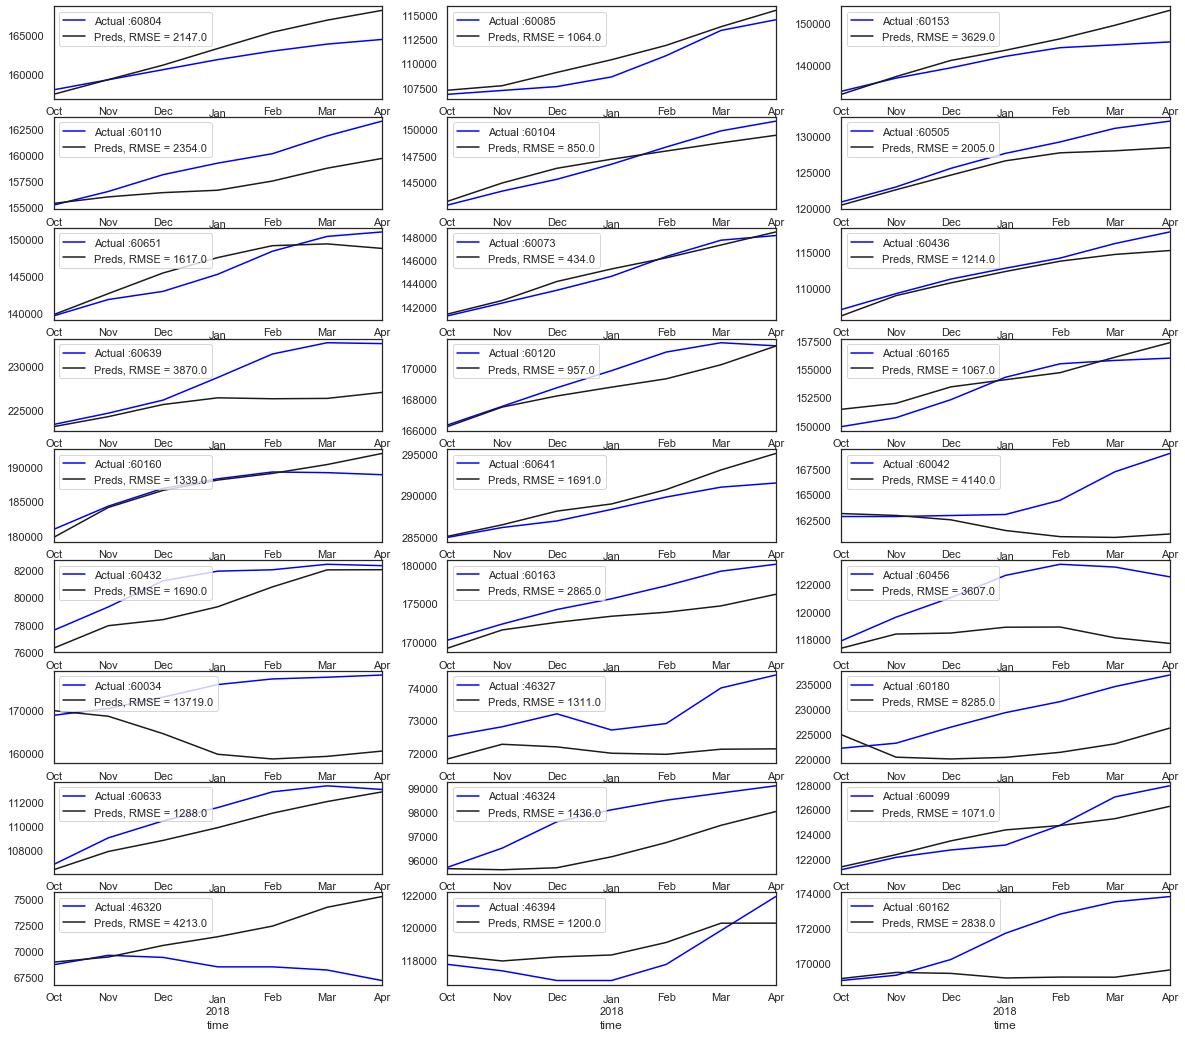

In [25]:
cfs.sarima_models_for_27_zipcodes()

# Model Evaluation

A few of the models performed really well, RMSE under 1000. Other's did not, RMSE over 10,000. To be confident in the recommendations we make to the real estate firm, we will consider only those models that produced a testing `RMSE under 2500`. 

This further trimmed down our zip codes to these 18 zip codes:

`60804`, `60085`, `60110`, `60104`, `60505`, `60651`, `60073`, `60436`, `60120`, `60165`, `60160`, `60641`, `60432`, `46327`, `60633`, `46324`, `60099`, `46394`

We retrained our models for these zipcodes, but this time included both the training and testing data so as to be able to make better forecasts using as many datapoints in training our models.

We then made forecasts for a time period of 1 year for each of our zip codes and obtained these values

In [26]:
forecasts = cfs.sarima_models_top_18()

In [27]:
forecast_df = pd.DataFrame(forecasts,index=pd.date_range(start='2018-04-01',
                                                         end='2019-03-01',
                                                         freq='MS'))
forecast_df.tail(3)

,60804,60085,60110,60104,60505,60651,60073,60436,60120,60165,60160,60641,60432,46327,60633,46324,60099,46394
2019-01-01,175852.837638,122135.222780,174030.147492,159712.257629,143166.081359,164134.228301,155079.765006,128767.611425,180143.332740,166176.025203,204298.939140,304238.636140,89676.594436,80977.099922,123795.370032,105721.716646,136418.658155,128305.491985
2019-02-01,177048.676859,124507.347527,175640.553518,160512.337497,144639.436351,165807.912954,156425.371723,129966.905853,180822.839891,167562.106190,204468.636207,305534.993810,90269.211222,82015.521630,124295.577434,106432.544426,138320.017462,130165.006052
2019-03-01,178168.185987,125879.510985,176895.126858,161579.915551,145509.289992,166200.730537,156962.667098,130963.013708,181015.867521,169099.290571,204563.597437,306163.892514,90452.135045,82363.512957,124489.382292,107079.100341,139389.346224,131822.115289


## ROI calculations

Our next step was to caluculate the Returns that could be generated on each of these regions if we invested in them in April 2018. These returns are calculated as the difference between the appreciated market value of homes in April 2019. These returns are only limited to the change in market value, however, if an investment is made in real-estate property there are other incomes that can also be generated such as rental income, other income from businesses running at these properties, etc. Such calculations are beyond the scope of our project. We have limited our ROI definition for this project to only reflect the change in market value of properties.


##### $\text{ROI for forecasted returns}  = \dfrac{\text{Value  in  April  2019  -  Value  in  April  2018}}{\text{Value  in  April  2019}} * 100$

### Top 5 ZipCodes based on ROI :

 **`46327`** - Hammond Indiana, East Chicago, Lake County: **`17.77%`**
 
 **`60505`** - Aurora Illinois, Kane County : **`10.67%`**
 
 **`60436`** - Joliet Illinois, Will COunty: **`10.64%`**
 
 **`60651`** - Chicago Illinois, Humboldt Park, Cook County: **`10.10%`**
 
 **`60633`** - Chicago Illinois, Burnham, Cook County: **`9.44%`**
 
  ### Visualizing the time series, model predictions and forecasts for our top 5 regions
 
![top_5_regions](../../report/figures/forecasts.png)

The dotted lines are the actual market value of median property prices over the years, the hazy solid lines are predictions of our respective models for each time series, and the bold solid lines are the forecasted values for each time series. 

# Conclusion:

This project set out to discover top five Zip Codes in the Chicago Metro area for our investment firm to make their investments in.  Our analysis and models found that 46327, 60505, 60436, 60651, 60633 areas were safe to invest in. These areas generated satisfactory returns when compared to other regions in the Chicago Metro area. They avaraged around 10% ROI anually, better than average annual stock market returns (around 7%).

We also found that:
- The regions discovered are spread out around the Chicago Metro area, suggesting that risk can be mitigated through diversification.
- We find that the amount required to invest in these regions varies from USD 75,000 to USD 150,000 providing a good mix of investment opportunity for the firm.
- We find that the ROI calculated only reflects the base return from investment. Other income opportunities such as rental income, income from business operations carried out in the property premises, etc can generate more returns.
